Menentukan Lokasi Family Mart di Kota Depok

Studi Kasus :
Klien meminta untuk menemukan lokasi yang cocok untuk membuat family mart di Kota Depok karena melihat peluang bisnis yang bagus untuk merchant ini namun belum banyak yang cabang family mart di Kota Depok. Kriteria yang di inginkan adalah ruko yang di jual dengan harga yang terjangkau, masuk ke dalam kawasan strategis dengan status sosial ekonomi yang tinggi, dan bebas dari risiko banjir.

Data yang di gunakan 
1. Properti Ruko dijual
2. Wilayah Risiko Bencana Banjir
3. Status ekonomi sosial kota depok
4. Family Mart di Kota Depok


In [10]:
import os
import geopandas as gpd
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt
import json
import seaborn as sns
from shapely.geometry import shape
from IPython.display import display
import numpy as np


In [11]:
# Mengambil Data dari API

urls = {"Ruko" :"https://geoserver.mapid.io/layers_new/get_layer?api_key=d3214c89a05940bfb952dd18e8b7cfd0&layer_id=68ae5a1ab2fcc5561a312546&project_id=68ae58924a3bb7db3134586e&limit=10000",
        "Risiko Banjir" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d3214c89a05940bfb952dd18e8b7cfd0&layer_id=68ae5ad9b2fcc5561a312d2a&project_id=68ae58924a3bb7db3134586e&limit=10000",
        "Status Sosial Ekonomi" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d3214c89a05940bfb952dd18e8b7cfd0&layer_id=68ae5e09b2fcc5561a313fcc&project_id=68ae58924a3bb7db3134586e&limit=10000",
        "Kompetitor" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d3214c89a05940bfb952dd18e8b7cfd0&layer_id=68ae5e72b2fcc5561a314089&project_id=68ae58924a3bb7db3134586e&limit=10000"}
data = {}
for key in urls:
    response = requests.get(urls[key])
    if response.status_code == 200:
        data[key] = response.json()
        print(f"API {key} Berhasil Dimuat")
    else:
        print(f"Gagal memuat {key}, status:", response.status_code)


API Ruko Berhasil Dimuat
API Risiko Banjir Berhasil Dimuat
API Status Sosial Ekonomi Berhasil Dimuat
API Kompetitor Berhasil Dimuat


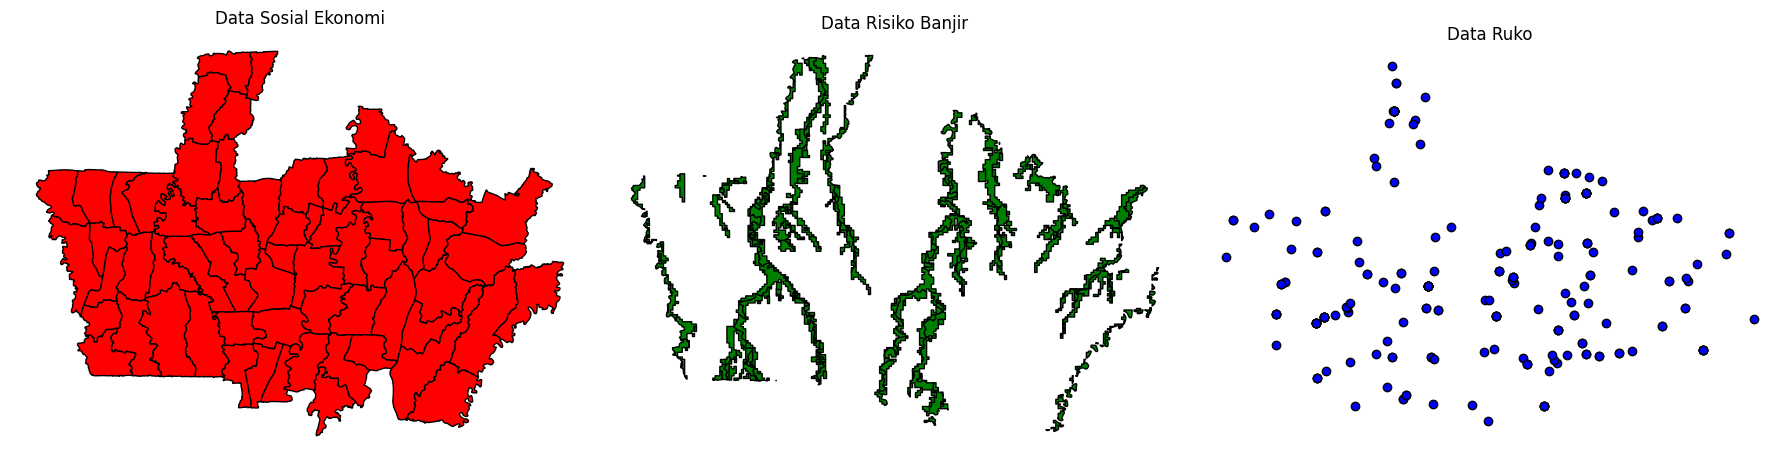

In [12]:

#Menambahkan skor pada setiap layer

def get_data(urls, layer_name):
    response = requests.get(urls)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        if layer_name == "Status Sosial Ekonomi":
            gdf["SKOR_SosEko"] = gdf.get("SOCIOECONOMIC STATUS", pd.Series([""]*len(gdf))).astype(str).str.upper().map({"MENENGAH ATAS":1, "ATAS":2}).fillna(0)
        elif layer_name == "Risiko Banjir":
            gdf["SKOR_BANJIR"] = gdf.get("KELAS_RISIKO", pd.Series([""]*len(gdf))).astype(str).str.upper().map({"TINGGI":1, "SEDANG":2}).fillna(0)
        elif layer_name == "Ruko":
            harga = pd.to_numeric(gdf.get("HARGA (Rp)", pd.Series([0]*len(gdf))), errors='coerce')
            gdf["SKOR_RUKO"] = np.where(harga >= 1500000000, 2, np.where(harga >= 200000000, 3, 1))
        return gdf
    return gpd.GeoDataFrame()

# Mengambil Data dari semua Layer
gdf_soseko = get_data(urls["Status Sosial Ekonomi"], "Status Sosial Ekonomi")
gdf_banjir = get_data(urls["Risiko Banjir"], "Risiko Banjir")
gdf_ruko = get_data(urls["Ruko"], "Ruko")
gdf_kompetitor = get_data(urls["Kompetitor"], "Kompetitor")

# The SKOR_SosEko column is already set in get_data, so this line can be removed.
# If you want to explicitly set it again, use:


#Visualisasi Data Variable menggunakan Matplotlib
def visualize_data(gdfs):
    fig, axes = plt.subplots(1, len(gdfs), figsize=(18,6))
    color_map = ['red', 'green', 'blue']
    for ax, (name, gdf), color in zip(axes, gdfs.items(), color_map):
        gdf.plot(ax=ax, color=color, edgecolor='black')
        ax.set_title(name)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Menampilkan visual dari ketiga variabel

visualize_data({"Data Sosial Ekonomi": gdf_soseko, "Data Risiko Banjir": gdf_banjir, "Data Ruko": gdf_ruko})
            



In [13]:
#Menambahkan faktor kompetitor

intersection_kompetitor = gdf_kompetitor
if not gdf_soseko.empty:
    intersection_kompetitor = gpd.overlay(intersection_kompetitor, gdf_soseko, how='intersection', keep_geom_type=False)

intersection_kompetitor [["KECAMATAN_1","DESA_1"]]

,KECAMATAN_1,DESA_1
0,SUKMAJAYA,TIRTAJAYA
1,CIMANGGIS,HARJAMUKTI


Berdasarkan hasil overlay, di ketahui Family Mart lain (Kompetitor) ada di Kecamatan Sukmajaya dan Cimanggis. Ruko yang berada di 2 Kecamatan ini akan menjadi faktor negatif dalam skoring

In [14]:
KECAMATAN = gdf_soseko["KECAMATAN"]
gdf_soseko["SKOR_KOMPETITOR"] = np.where(KECAMATAN == "SUKMAJAYA", 1, np.where(KECAMATAN == "CIMANGGIS", 1, 0))

In [15]:

# Mengatasi Nilai Null
gdf_soseko['SKOR_SosEko'] = gdf_soseko['SKOR_SosEko'].fillna(0)
gdf_banjir['SKOR_BANJIR'] = gdf_banjir['SKOR_BANJIR'].fillna(0)
gdf_ruko['SKOR_RUKO'] = gdf_ruko['SKOR_RUKO'].fillna(0)

#Analisis Intersect / Overlay Intersect
intersection_gdf = gdf_ruko
if not gdf_soseko.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_soseko, how='intersection', keep_geom_type=False)
if not gdf_banjir.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_banjir, how='intersection', keep_geom_type=False)

# Fix Geometry
intersection_gdf = intersection_gdf[intersection_gdf.is_valid]
intersection_gdf['geometry'] = intersection_gdf['geometry'].apply(lambda x: x.make_valid() if not x.is_valid else x)

#Mengatasi Nilai Null Pasca Fix Geometry
intersection_gdf['SKOR_SosEko'] = intersection_gdf['SKOR_SosEko'].fillna(0)
intersection_gdf['SKOR_BANJIR'] = intersection_gdf['SKOR_BANJIR'].fillna(0)
intersection_gdf['SKOR_RUKO'] = intersection_gdf['SKOR_RUKO'].fillna(0)

#Kalkulasi skoring
intersection_gdf['SKOR_TOTAL']= intersection_gdf['SKOR_SosEko'] + intersection_gdf['SKOR_BANJIR'] + intersection_gdf['SKOR_RUKO'] - intersection_gdf['SKOR_KOMPETITOR']

#Klasifikasi
intersection_gdf['REKOMENDASI_RUKO'] = pd.cut(
    intersection_gdf['SKOR_TOTAL'],
    bins=[2,5,7],
    labels=['Tidak direkomendasikan', 'Direkomendasikan'],
    include_lowest=True)

intersection_gdf[["SKOR_SosEko", "SKOR_BANJIR","SKOR_RUKO", "SKOR_TOTAL", "REKOMENDASI_RUKO","KECAMATAN_1", "DESA_1"]].head(20)


,SKOR_SosEko,SKOR_BANJIR,SKOR_RUKO,SKOR_TOTAL,REKOMENDASI_RUKO,KECAMATAN_1,DESA_1
0,2,1.0,1,4.0,Tidak direkomendasikan,SAWANGAN,PENGASINAN
1,2,2.0,2,5.0,Tidak direkomendasikan,CIMANGGIS,TUGU
2,2,1.0,3,6.0,Direkomendasikan,SAWANGAN,PENGASINAN
3,2,1.0,1,4.0,Tidak direkomendasikan,SAWANGAN,PENGASINAN
4,2,1.0,2,5.0,Tidak direkomendasikan,SAWANGAN,KEDAUNG
5,2,1.0,2,4.0,Tidak direkomendasikan,SUKMAJAYA,TIRTAJAYA
6,2,1.0,2,4.0,Tidak direkomendasikan,SUKMAJAYA,SUKMAJAYA
7,2,1.0,3,5.0,Tidak direkomendasikan,CIMANGGIS,MEKARSARI
8,2,1.0,2,5.0,Tidak direkomendasikan,BEJI,TANAH BARU
9,2,2.0,3,7.0,Direkomendasikan,PANCORAN MAS,MAMPANG


In [16]:
# Tentukan warna untuk setiap kategori rekomendasi
color_dict = {
    'Direkomendasikan': 'green',
    'Tidak direkomendasikan': 'red'
}

# Tentukan ukuran titik (misal berdasarkan harga, atau tetap)
def get_radius(row):
    # Contoh: radius proporsional terhadap harga, dengan batas minimum dan maksimum
    try:
        harga = float(row['HARGA (Rp)'])
    except (ValueError, TypeError):
        return 5
    if pd.isnull(harga):
        return 5
    return min(max(harga / 1e9, 5), 15)  # skala harga (Rp) ke radius

# Tentukan pusat peta berdasarkan rata-rata koordinat ruko hasil intersection
map_center = [
    intersection_gdf.geometry.y.mean(),
    intersection_gdf.geometry.x.mean()
]

# Buat peta dengan titik
mymap = folium.Map(location=map_center, zoom_start=12)

for idx, row in intersection_gdf.iterrows():
    rekom = row['REKOMENDASI_RUKO']
    color = color_dict.get(rekom, 'gray')
    radius = get_radius(row)
    popup_text = f"""
    <b>Nama:</b> {row['NAMA']}<br>
    <b>Harga:</b> {row['HARGA (Rp)']}<br>
    <b>Kecamatan:</b> {row['KECAMATAN']}<br>
    <b>Rekomendasi:</b> {row['REKOMENDASI_RUKO']}
    """
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(mymap)

mymap


In [17]:
out = r"D:\Bahan Untuk Porto\WebGIS\Rekomendasi_Ruko_FamilyMart.geojson"

os.makedirs(os.path.dirname(out), exist_ok=True)
intersection_gdf.to_file(out, driver="GeoJSON", encoding="utf-8")
print("File Tersimpan di:", out)

File Tersimpan di: D:\Bahan Untuk Porto\WebGIS\Rekomendasi_Ruko_FamilyMart.geojson


d:\Bahan Untuk Porto\WebGIS\python\TASK_4\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
